# Trabalho 4 - Operações Geométricas

## Scanner doméstico usando um celular.

Os filhos do professor de visão computacional são aficionados por Star Wars. O maiorzinho queria uma imagem de um storm trooper como plano de fundo para o seu tablet. Contudo, o scanner de casa está quebrado e o salário do professor está muito atrasado. O pior é que o governador Pezão nem sequer diz quando vai pagar os três salário em atraso. Como a grana está curta, o professor resolveu usar câmera do celular. No entanto, é sabido que a imagem obtida pela câmera impõe à imagem original uma geometria projetiva e esta distorção precisa ser compensada já que o garoto ficou muito triste com a qualidade do resultado obtido pela câmera. Felizmente, como o pai dos meninos é professor, ele propôs que seus alunos da UERJ resolvessem este problema como trabalho para a disciplina. Para facilitar a tarefa, o professor fotografou a imagem do storm trooper sobre uma folha de papel A4 que serve como referência. Obtenha a transformação projetiva que recupere a geometria da imagem original e reconstrua-a usando a interpolação bilinear. Veja a seguir a imagem de entrada.

Faça toda a álgebra linear manualmente, das bibliotecas usadas no curso, você só pode usar as funções  ```imread``` e ```imwrite```.

-------

#### Bibliotecas Relevantes

Neste trabalho iremos utilizar as seguintes bibliotecas:

* opencv
* numpy
* matplotlib
* scipy


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance as dist

np.set_printoptions(linewidth = 250, suppress = True)

-------

#### Definição de Funções

A seguir estão as funções que foram criadas para resolver o problema, cada função contém uma breve descrição da operação que está executando.

In [2]:
C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [0, 255, 255]])

In [3]:
def img2binary(img, threshold = 60):
    """Binarization of image with threshold given"""
    return threshold < img

In [4]:
def roberts(img):
    """Apply Roberts filter to image"""
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F,
                                              cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F,
                                              cv.flip(k_robertsy, -1)))
    
    return robertsx + robertsy

In [5]:
def binary_roberts(img, threshold = 60):
    """Returns roberts image in binary scale"""
    return img2binary(roberts(img), threshold).astype(np.uint8)

In [6]:
def clockwise_sort(points):
    """Sort the corners in clockwise starting from top left corner"""
    tl = points[np.argsort(points[:, 0]), :][0]
    points = np.delete(points, 
                       np.where(np.all(points == tl, axis = 1)), axis = 0)
    bl = points[np.argsort(points[:, 1]), :][0]
    points = np.delete(points, 
                       np.where(np.all(points == bl, axis = 1)), axis = 0)
    tr = points[np.argsort(points[:, 0]), :][0]
    br = points[(points != tr)[:, 0]][0]
    
    return np.array([tl, tr, br, bl], dtype = np.int)

In [7]:
def detect_corners(img):
    """Detect corners based on non zero pixel of image object borders"""
    b = np.where(img > 0)
    p1 = np.array([b[0][np.argmin(b[0])], b[1][np.argmin(b[0])]])
    p2 = np.array([b[0][np.argmax(b[1])], b[1][np.argmax(b[1])]])
    p3 = np.array([b[0][np.argmax(b[0])], b[1][np.argmax(b[0])]])
    p4 = np.array([b[0][np.argmin(b[1])], b[1][np.argmin(b[1])]])
    p5 = np.array([b[1].min(), b[0].min()])
    p6 = np.array([b[1].min(), b[0].max()])
    p7 = np.array([b[1].max(), b[0].max()])
    p8 = np.array([b[1].max(), b[0].min()])
    
    corners = np.array([p1, p2, p3, p4, p5, p6, p7, p8])
    
    return np.unique(corners[img[corners[:,0],
                                 corners[:,1]] == 1], axis = 0)

In [8]:
def cornerfy_from_array(arrayin, fileout = ''):
    """Calls binary_roberts on input image and returns the roberts 
    lines and the corners sorted clockwise"""
    roberts_binary = binary_roberts(arrayin)
    corners = detect_corners(roberts_binary)
    return roberts_binary, clockwise_sort(corners)

In [9]:
def true_corners(img, corners):
    """Move the corners found by cornerfy_from_array to the exact 
    position with the original image"""
    for i in range(len(corners)):
        if img[tuple(corners[i])] == 0:
            ind = tuple(corners[i])
            idx = np.argwhere(img)
            idx = idx[~(idx == ind).all(1)]
            corners[i] = idx[((idx - ind)**2).sum(1).argmin()]
    
    return clockwise_sort(corners)

In [10]:
def assemble_matrix(in_corners, out_corners):
    """Creates the matrix for the least square"""
    A = np.zeros((len(in_corners), 8))

    for i in range(0, len(in_corners), 2):
        A[i, 0] = in_corners[i]
        A[i, 1] = in_corners[i + 1]
        A[i, 2] = 1
        A[i, 3] = A[i, 4] = A[i, 5] = 0
        A[i, 6] = - in_corners[i] * out_corners[i]
        A[i, 7] = - in_corners[i + 1] * out_corners[i]
        A[i + 1, 0] = A[i + 1, 1] = A[i + 1, 2] = 0
        A[i + 1, 3] = in_corners[i]
        A[i + 1, 4] = in_corners[i + 1]
        A[i + 1, 5] = 1
        A[i + 1, 6] = - in_corners[i] * out_corners[i + 1]
        A[i + 1, 7] = - in_corners[i + 1] * out_corners[i + 1]
        
    return A

In [11]:
def swap_columns(mat):
    """swap_columns changes the position of x and y (width and height)"""
    swap = np.copy(mat[:,[1,0]])
    return swap

In [12]:
def strip_matrix(mat):
    """Turns a matrix (m x n) into a vector (m*n x 1)"""
    if mat.shape[1] != 1:
        mat = mat.reshape(-1, 1)
    
    return mat

In [13]:
def geometric_transformation(in_corners, out_corners):
    """Computes the geometric transformation matrix"""
    in_corners = strip_matrix(swap_columns(in_corners))
    out_corners = strip_matrix(swap_columns(out_corners))
    
    A = assemble_matrix(in_corners, out_corners)
    X = np.linalg.inv(A.T @ A) @ A.T @ out_corners

    return np.array([[X[0,0], X[1,0], X[2,0]],
                     [X[3,0], X[4,0], X[5,0]],
                     [X[6,0], X[7,0], 1],])

In [14]:
def bilinear_interpolation(tx, ty, img_src):
    """For each pixel of the new image computes its intensity value by
    bilinear interpolation of original image"""
    n = np.floor(ty).astype('int')
    s = np.ceil(ty).astype('int')
    w = np.floor(tx).astype('int')
    e = np.ceil(tx).astype('int')
    
    q00 = img_src[n, w]
    q01 = img_src[n, e]
    
    q10 = img_src[s, w]
    q11 = img_src[s, e]
    
    q = np.array([[q00, q01], [q10, q11]])

    if e - w == 0:
        dw = 1
    else:
        dw = e - w
    if s - n == 0:
        dh = 1
    else:
        dh = s - n
    
    b = dw * dh
        
    x = np.array([(e - tx), (tx - w)])
    y = np.array([(s - ty), (ty - n)])

    bi_interp = (1/b) * x @ q @ y.T
    
    return bi_interp.astype(np.int)

-------

## Figuras/Imagens

Carregando a figura do Stormtrooper

In [15]:
stormtrooper = cv.imread('../images/IMG_20170615_082455.jpg', 0)

Cria o painel do A4 em branco (sem intensidade nos pixels)

In [16]:
A4 = np.zeros((1754, 1240), dtype = np.uint8)

------

## Teste da Identificação dos Cantos

Para fazer a correção projetiva da imagem do Stormtrooper, primeiro precisamos conseguir identificar os cantos do objeto. 

Usando as imagens do losango e do quadrado vamos testar o algoritmo para identificar os cantos do objeto de interesse. Abaixo temos a criação do losango e do quadrado.

In [17]:
diamond = np.uint8([[(30 <= x + y) &
                     (10 >= -x + y) &
                     (-10 <= -x + y) &
                     (50 >= x + y) 
                     for y in range(41)] for x in range(41)]) * 255

square = np.uint8([[(x >= 10) &
                    (x <= 30) &
                    (y >= 10) &
                    (y <= 30) 
                    for y in range(41)] for x in range(41)]) * 255

Abaixo criamos as matrizes com os cantos identificados para o losango e o quadrado. Primeiro usandos a função baseada na identificação de margens pelo filtro de roberts, e então fazemos o reposicionamento correto do canto com a imagem original.

In [18]:
diamond_roberts, diamond_corners = cornerfy_from_array(diamond)
diamond_corners = true_corners(diamond, diamond_corners)

square_roberts, square_corners = cornerfy_from_array(square)
square_corners = true_corners(square, square_corners)

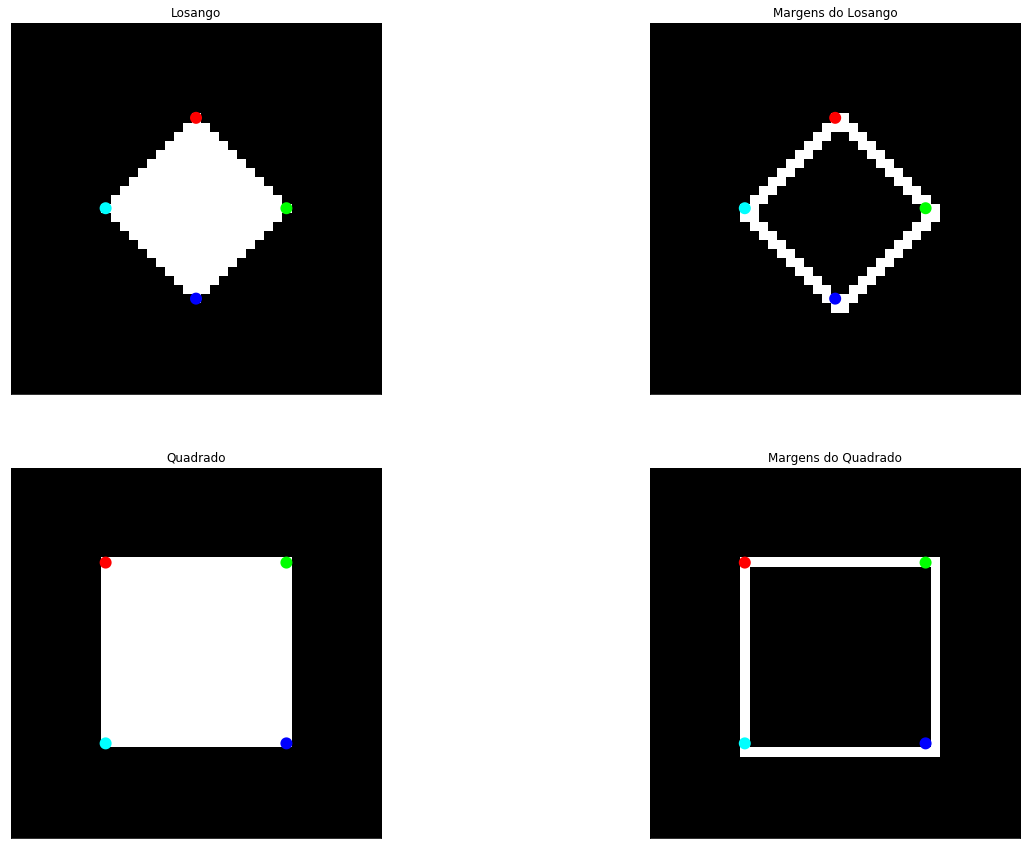

In [28]:
fig = plt.figure(figsize = (21,15))

ax0 = fig.add_subplot(2, 2, 1)
ax0.imshow(diamond, cmap = 'gray')
ax0.scatter(diamond_corners[:,1], diamond_corners[:,0], 
            marker = 'o', color = C/255.0, linewidths = 6)
ax0.set_title('Losango')
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(2, 2, 2)
ax1.imshow(diamond_roberts, cmap = 'gray')
ax1.scatter(diamond_corners[:,1], diamond_corners[:,0], 
            marker = 'o', color = C/255.0, linewidths = 6)
ax1.set_title('Margens do Losango')
plt.xticks([])
plt.yticks([])


ax2 = fig.add_subplot(2, 2, 3)
ax2.imshow(square, cmap = 'gray')
ax2.scatter(square_corners[:,1], square_corners[:,0], 
            marker = 'o', color = C/255.0, linewidths = 6)
ax2.set_title('Quadrado')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(2, 2, 4)
ax3.imshow(square_roberts, cmap = 'gray')
ax3.scatter(square_corners[:,1], square_corners[:,0], 
            marker = 'o', color = C/255.0, linewidths = 6)
ax3.set_title('Margens do Quadrado')
plt.xticks([])
plt.yticks([])

plt.show()

A figura acima compara a imagem original e os cantos (ao lado esquerdo), e o resultado do filtro de roberts e os cantos (lado direito) depois de terem sido reposicionados. O filtro de roberts desloca a margem, de modo que os cantos foram reposicionados em função da presença de intensidade no pixel na imagem original.

A forma como foi implementada a identificação dos cantos da imagem de entrada funciona para o caso do losango e quadrado em preto e branco.

-------

## Aplicação na Imagem Sugerida

Abaixo realizamos os procedimentos para identificar os cantos da imagem do stormtrooper, e, na sequência, fazer a transformação para as dimensões de uma imagem em folha A4 de 150 ppi.

In [20]:
stormtrooper_roberts, stormtrooper_corners = cornerfy_from_array(stormtrooper)
stormtrooper_corners = true_corners(stormtrooper, stormtrooper_corners)

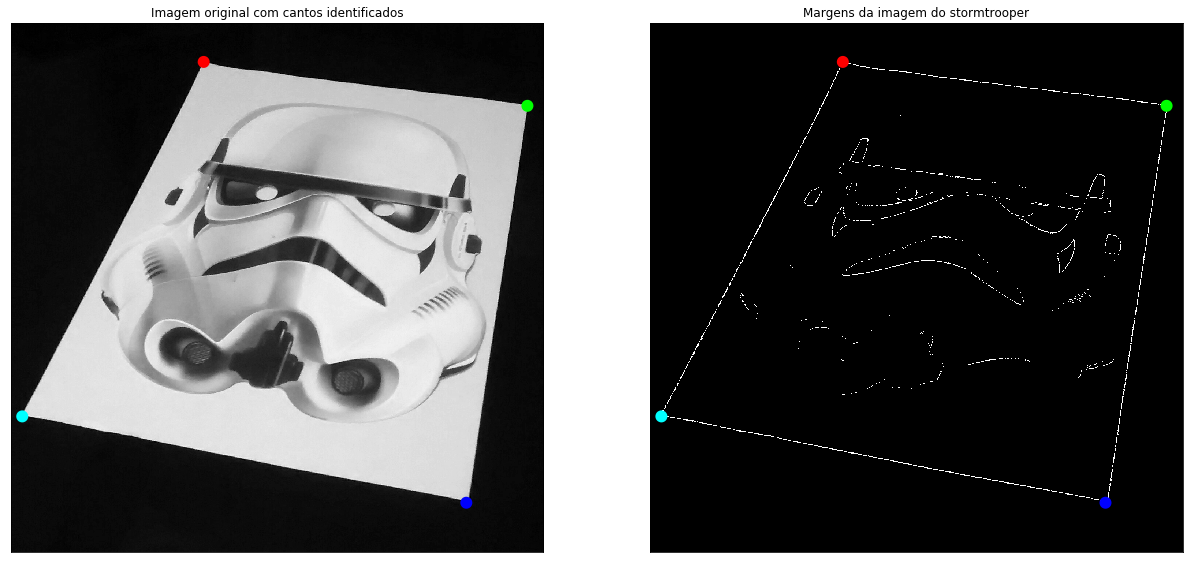

In [29]:
fig = plt.figure(figsize = (21,15))

ax0 = fig.add_subplot(1, 2, 1)
ax0.imshow(stormtrooper, cmap = 'gray')
ax0.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0],
           marker = 'o', color = C/255.0, linewidths = 6)
ax0.set_title('Imagem original com cantos identificados')
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(stormtrooper_roberts, cmap = 'gray')
ax1.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0],
            marker = 'o', color = C/255.0, linewidths = 6)
ax1.set_title('Margens da imagem do stormtrooper')
plt.xticks([])
plt.yticks([])

plt.show()

Acima podemos ver a imagem original com seus cantos identificados, assim como o resultado do filtro de roberts sobreposto com os cantos.

In [22]:
A4_corners = np.array([[0,0], [0, 1240], [1754, 0], [1754, 1240]])
A4_corners = clockwise_sort(A4_corners)

A imagem abaixo mostra a relação dos cantos da imagem A4 com a imagem original. As cores de cada canto identifica a correspondência entre imagem original e destino.

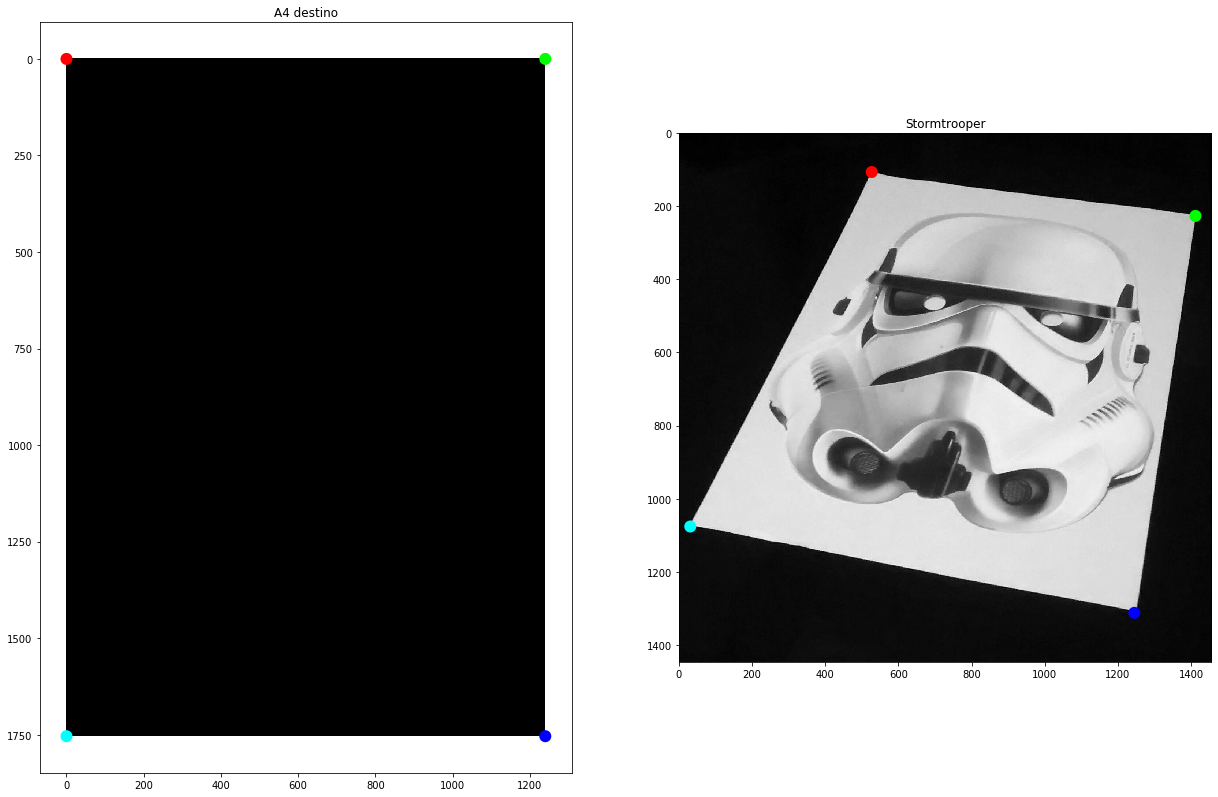

In [30]:
point = 2

fig = plt.figure(figsize = (21,15))

ax0 = fig.add_subplot(1, 2, 1)
ax0.imshow(A4, cmap = 'gray')
ax0.scatter(A4_corners[:,1], A4_corners[:,0], 
           marker = 'o', color = C/255.0, linewidths = 6)
ax0.set_title('A4 destino')

ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(stormtrooper, cmap = 'gray')
ax1.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0],
           marker = 'o', color = C/255.0, linewidths = 6)
ax1.set_title('Stormtrooper')

plt.show()

A relação dos cantos entre o stromtrooper e o A4 está feita abaixo

In [53]:
print("Cantos")
print("Stormtrooper ----> A4")
print("(x, y) \t\t (u, v)")
for i, j in zip(stormtrooper_corners, A4_corners):
    print('{:8s} \t {:8s}'.format(str(i), str(j)))

Cantos
Stormtrooper ----> A4
(x, y) 		 (u, v)
[107 527] 	 [0 0]   
[ 227 1412] 	 [   0 1240]
[1312 1245] 	 [1754 1240]
[1076   31] 	 [1754    0]


### Criação da Matriz de Transformação Geométrica

a variável ```geo_mat``` corresponde a matriz da transformação geométrica. Neste caso, fizemos a matriz considerando a transformação do papel A4 para a imagem do stormtrooper.

In [25]:
M, N = 1754, 1240
img_new = np.zeros((M, N))
geo_mat = geometric_transformation(A4_corners, 
                                   stormtrooper_corners)

Uma vez que a matriz de transformação é calculada, para cada pixel da imagem do papel A4 podemos colocar a intensidade, a partir da imagem do stormtrooper original, pela interpolação bilinear. Este processo é feito pixel a pixel, e é a etapa mais demorada computacionalmente. Caso a imagem final fosse um papel A4 com maior número de ppi, haveriam mais pixels para se determinar as intensidades.

In [26]:
for v in np.arange(img_new.shape[0]):
    for u in np.arange(img_new.shape[1]):
        pixel = geo_mat @ np.array([u, v, 1])
        pixel = pixel / pixel[2]
        img_new[v, u] = bilinear_interpolation(pixel[0], 
                                               pixel[1], 
                                               stormtrooper)

Abaixo temos ao lado esquerdo a imagem de entrada, e ao lado direito a imagem final depois da transformação ser aplicada.

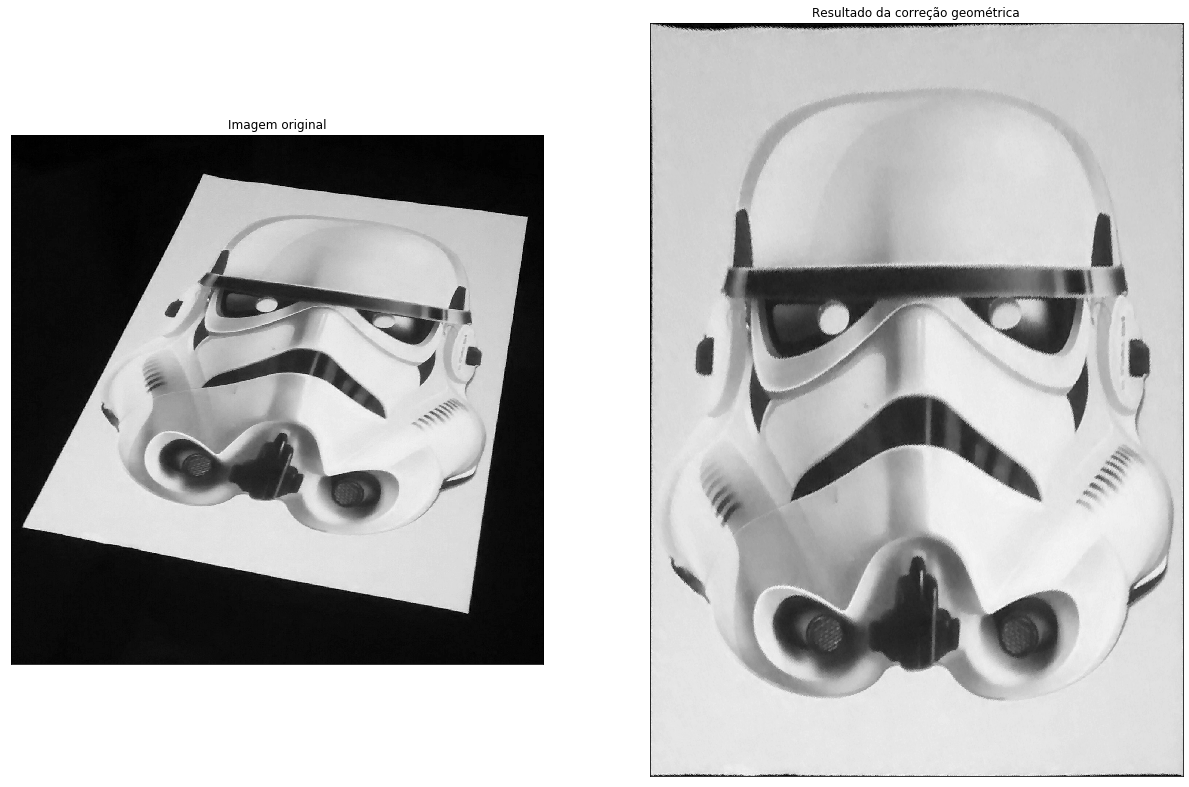

In [31]:
fig = plt.figure(figsize = (21,15))

ax0 = fig.add_subplot(1, 2, 1)
ax0.imshow(stormtrooper, cmap = 'gray')
ax0.set_title('Imagem original')
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(img_new, cmap = 'gray')
ax1.set_title('Resultado da correção geométrica')
plt.xticks([])
plt.yticks([])

plt.show()